In [16]:
import pandas as pd
import ollama
from ollama import chat
from pydantic import BaseModel
#from openai import OpenAI

# Set Display Settings
pd.set_option('display.max_colwidth', 70)

In [2]:
data=pd.read_excel("/Users/santhanakrishnans/Downloads/ford_service_review_processed.xlsx")

data=data.dropna(subset=['review'])
data["review_original"]=data["review"]
data=data.reset_index()


In [7]:

import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from ollama import chat
from tqdm import tqdm

def analyze_single_review(review, predefined_topics, allowed_sentiments, index):
    prompt_template = """
        Analyze the following review and do the following:
        1. Identify the key topics talked about in the review only out of the following comma-separated list: {topics}.
        2. Identify the sentiments expressed in the review from the following comma-separated list: {sentiments}.

        Return the output in this format:
        Key topics: [comma-separated list of topics]
        Sentiment: [sentiment]
    """
    prompt = prompt_template.format(
        topics=", ".join(predefined_topics),
        sentiments=", ".join(allowed_sentiments),
    ) + f"\n\nReview {index + 1}: {review}"

    response = chat(
        model="llama3.2",
        messages=[
            {"role": "system", "content": "You are a helpful assistant for analyzing reviews."},
            {"role": "user", "content": prompt},
        ],
        options={'temperature': 0.01}
    )

    if hasattr(response, "message") and hasattr(response.message, "content"):
        return {"index": index, "analysis": response.message.content.strip()}
    else:
        raise ValueError(f"Unexpected response format for review {index}:", response)


def analyze_reviews_in_parallel(dataframe, predefined_topics, allowed_sentiments, max_workers=4):
    reviews = dataframe["review"].tolist()
    results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        with tqdm(total=len(reviews), desc="Processing Reviews") as progress_bar:
            future_to_review = {
                executor.submit(
                    analyze_single_review, review, predefined_topics, allowed_sentiments, idx
                ): idx
                for idx, review in enumerate(reviews)
            }

            for future in as_completed(future_to_review):
                try:
                    result = future.result()
                    results.append(result)
                except Exception as e:
                    print(f"Error processing review {future_to_review[future]}: {e}")
                finally:
                    progress_bar.update(1)

    results.sort(key=lambda x: x["index"])

    dataframe["analysis"] = [result["analysis"] for result in results]

    return dataframe


if __name__ == "__main__":
    data = pd.DataFrame({
        "review": [
            "3 hours to change oil",
            "Always fairly quick to charge",
            "Always a good impression...and very attentive service"
        ]
    })

    predefined_topics = [
        'Product Quality', 'Staff', 'Service Time',
        'Music System', 'Recall', 'Brake',
        'Oil Change/Refill', 'Wheel/Tires',
        'Product Quality', 'Service Cost', 'Service Diagnostics',
        'Facilities', 'Windshield', 'Door', 'Battery',
        'Engine', 'Product Availability', 'Not Classified'
    ]
    allowed_sentiments = ["Positive", "Negative", "Neutral"]

    updated_data = analyze_reviews_in_parallel(data, predefined_topics, allowed_sentiments, max_workers=4)

    print(updated_data)

Processing Reviews: 100%|█████████████████████████| 3/3 [00:03<00:00,  1.19s/it]

                                                  review  \
0                                  3 hours to change oil   
1                          Always fairly quick to charge   
2  Always a good impression...and very attentive service   

                                                                analysis  
0         Key topics: Product Quality, Service Cost\nSentiment: Negative  
1         Key topics: Product Quality, Service Time\nSentiment: Positive  
2  Key topics: Product Quality, Staff, Service Time\nSentiment: Positive  


In [ ]:
updated_data["Key Topics"] = updated_data["analysis"].str.extract(r"Key topics:\s*([^\n]*)")
updated_data["Sentiment"] = data["analysis"].str.extract(r"Sentiment:\s*([^\n]*)")

# Drop the analysis column (optional)
updated_data = updated_data.drop(columns=["analysis"])

# Display the result
print(updated_data)


In [ ]:
updated_data.to_csv("/Users/santhanakrishnans/Downloads/llama3.2_base.csv")

In [ ]:
# Predefined topics
predefined_topics = [
    'Product Quality', 'Staff', 'Service Time', 'Music System', 'Recall',
    'Brake', 'Oil Change/Refill', 'Wheel/Tires', 'Service Cost',
    'Service Diagnostics', 'Facilities', 'Windshield', 'Door', 'Battery',
    'Engine', 'Product Availability', 'Not Classified', 'Customer Service',
    'Service Quality'
]


# Create a column for each predefined topic
for topic in predefined_topics:
    updated_data[topic] = updated_data["Key Topics"].apply(lambda x: 1 if isinstance(x, str) and topic in x else 0)

# Display the updated DataFrame
print(updated_data)

In [ ]:
updated_data.to_csv("/Users/santhanakrishnans/Downloads/llama3.2_base_topics_temp.csv")

In [ ]:
# Calculate the number of rows with no topics (excluding 'Not Classified')
topics_to_consider = [topic for topic in predefined_topics if topic != 'Not Classified']
no_topics_count = updated_data[topics_to_consider].sum(axis=1).eq(0).sum()

# Calculate the percentage of rows with no topics
no_topics_percentage = (no_topics_count / len(updated_data)) * 100

print(f"{no_topics_percentage:.2f}% of rows do not contain any topic from the predefined list (excluding 'Not Classified').")

In [ ]:
updated_data[predefined_topics]

In [ ]:
# Get the topic occurrence counts
topic_counts = updated_data[predefined_topics].sum().sort_values(ascending=False)

# Print the topic counts
print(topic_counts)

In [ ]:
topic_counts.to_csv("Topic_Distribution_zeroshot_temp.csv")

In [33]:
sentiment_data=pd.read_csv("/Users/santhanakrishnans/Downloads/llama3.2_base_topics.csv")

In [34]:
sentiment_data.columns

Index(['Unnamed: 0', 'index', 'serviceCentre', 'dummy', 'overall rating',
       'dummy1', 'geo_location', 'Unnamed: 5', 'Unnamed: 6', 'user',
       'Unnamed: 8', 'date', 'rating', 'review', 'Unnamed: 12', 'response',
       'review_original', 'Key Topics', 'Sentiment', 'Product Quality',
       'Staff', 'Service Time', 'Music System', 'Recall', 'Brake',
       'Oil Change/Refill', 'Wheel/Tires', 'Service Cost',
       'Service Diagnostics', 'Facilities', 'Windshield', 'Door', 'Battery',
       'Engine', 'Product Availability', 'Not Classified', 'Customer Service',
       'Service Quality'],
      dtype='object')

In [35]:
sentiment_data.rating

0        1 star
1        1 star
2        1 star
3        1 star
4        1 star
         ...   
1176    4 stars
1177    5 stars
1178    5 stars
1179    4 stars
1180    5 stars
Name: rating, Length: 1181, dtype: object

In [36]:
import pandas as pd
import re

# Remove the string "star" and any other special characters, and convert to int
sentiment_data['rating'] = sentiment_data['rating'].apply(lambda x: int(re.sub('[^0-9]', '', x)))

# Label the sentiment based on the rating
sentiment_data['sentiment_original'] = sentiment_data['rating'].apply(lambda x: 'Positive' if x > 3 else 'Neutral' if x == 3 else 'Negative')

In [37]:
sentiment_summary = sentiment_data['sentiment_original'].value_counts()
print(sentiment_summary).groupby()

sentiment_original
Positive    727
Negative    396
Neutral      58
Name: count, dtype: int64


AttributeError: 'NoneType' object has no attribute 'groupby'

In [38]:
sentiment_summary_AI = sentiment_data['Sentiment'].value_counts()
print(sentiment_summary_AI).groupby()

Sentiment
Positive                                                       684
Negative                                                       438
Neutral                                                         47
Not Classified                                                   8
None of the above (as no sentiment is explicitly mentioned)      1
Positive                                                         1
Name: count, dtype: int64


AttributeError: 'NoneType' object has no attribute 'groupby'

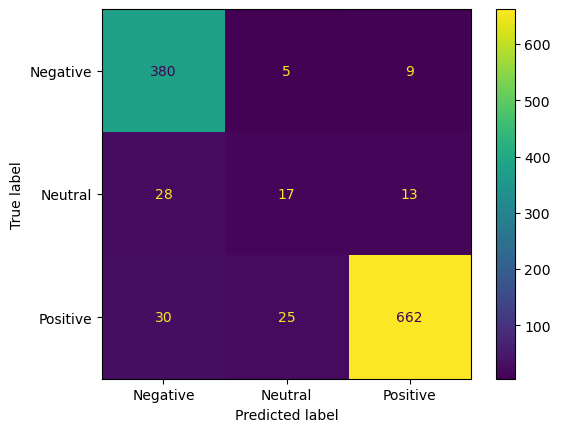

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
sentiment_data = sentiment_data[sentiment_data['Sentiment'].isin(["Positive", "Neutral", "Negative"])]
# Build the confusion matrix
cm = confusion_matrix(sentiment_data['sentiment_original'], sentiment_data['Sentiment'])

# Create a ConfusionMatrixDisplay object
cmd = ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive'])

# Plot the confusion matrix
cmd.plot()

In [42]:
from sklearn.metrics import confusion_matrix

# Build the confusion matrix
cm = confusion_matrix(sentiment_data['sentiment_original'], sentiment_data['Sentiment'])

# Calculate accuracy
accuracy = (cm[0,0] + cm[1,1] + cm[2,2]) / cm.sum()
print("Accuracy:", accuracy)

# Calculate precision for each class
precision_positive = cm[0,0] / (cm[0,0] + cm[1,0] + cm[2,0])
precision_neutral = cm[1,1] / (cm[0,1] + cm[1,1] + cm[2,1])
precision_negative = cm[2,2] / (cm[0,2] + cm[1,2] + cm[2,2])
print("Precision (Positive):", precision_positive)
print("Precision (Neutral):", precision_neutral)
print("Precision (Negative):", precision_negative)

# Calculate type 1 error (false positive rate) for each class
type1_error_positive = (cm[1,0] + cm[2,0]) / (cm[1,0] + cm[2,0] + cm[1,1] + cm[2,2])
type1_error_neutral = (cm[0,1] + cm[2,1]) / (cm[0,1] + cm[2,1] + cm[0,0] + cm[2,2])
type1_error_negative = (cm[0,2] + cm[1,2]) / (cm[0,2] + cm[1,2] + cm[0,0] + cm[1,1])
print("Type 1 Error (Positive):", type1_error_positive)
print("Type 1 Error (Neutral):", type1_error_neutral)
print("Type 1 Error (Negative):", type1_error_negative)

# Calculate type 2 error (false negative rate) for each class
type2_error_positive = cm[0,1] + cm[0,2]
type2_error_neutral = cm[1,0] + cm[1,2]
type2_error_negative = cm[2,0] + cm[2,1]
print("Type 2 Error (Positive):", type2_error_positive)
print("Type 2 Error (Neutral):", type2_error_neutral)
print("Type 2 Error (Negative):", type2_error_negative)

Accuracy: 0.9059024807527801
Precision (Positive): 0.867579908675799
Precision (Neutral): 0.3617021276595745
Precision (Negative): 0.9678362573099415
Type 1 Error (Positive): 0.07869742198100407
Type 1 Error (Neutral): 0.027985074626865673
Type 1 Error (Negative): 0.05250596658711217
Type 2 Error (Positive): 14
Type 2 Error (Neutral): 41
Type 2 Error (Negative): 55
